In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Add
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split # type: ignore
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

import pandas as pd
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

import os
import cv2

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
def fsbPlotModelTraining(historia, inuModdelName='ResNet50'):
    plt.plot(historia.history['accuracy'], label='Train Precisión')
    plt.plot(historia.history['val_accuracy'], label='Test Precisión')
    plt.title('Evolución de la Precisión del Modelo '+inuModdelName)
    plt.xlabel('Epoch')
    plt.ylabel('Precisión')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Plot training & validation loss values
    plt.plot(historia.history['loss'], label='Pérdida')
    plt.plot(historia.history['val_loss'], label='Pérdida')
    plt.title('Evolución de la Pérdida del Modelo '+inuModdelName)
    plt.xlabel('Epoch')
    plt.ylabel('Pérdida')
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

In [ ]:
def fsbConfMatrix(modelo,XVal,YVal):
    ypredic=modelo.predict(XVal)

    y_test_class = np.argmax(YVal,axis=1)
    y_pred_class = np.argmax(ypredic,axis=1)

    #Accuracy of the predicted values
    print(classification_report(y_test_class, y_pred_class)) # Precision , Recall, F1-Score & Support
    cm = confusion_matrix(y_test_class, y_pred_class)
    print(cm)
    # visualize the confusion matrix in a heat map
    df_cm = pd.DataFrame(cm)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

In [3]:
train_data = np.load('/content/drive/MyDrive/Colab_Notebooks/Project_2/dataset.npz')
images = train_data['x']
labels = train_data['y']
######################## Preprocessing ##########################
# Set channel
channel = images.shape[-1]

# to 64 x 64 x channel
real = np.ndarray(shape=(images.shape[0], 64, 64, channel))
for i in range(images.shape[0]):
    real[i] = cv2.resize(images[i], (64, 64)).reshape((64, 64, channel))

# Train test split, for autoencoder (actually, this step is redundant if we already have test set)
x_train, x_test, y_train, y_test = train_test_split(real, labels, test_size=0.3, shuffle=True, random_state=42)

# It is suggested to use [-1, 1] input for GAN training
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_test = (x_test.astype('float32') - 127.5) / 127.5

# Get image size
img_size = x_train[0].shape
# Get number of classes
n_classes = len(np.unique(y_train))

# OneHot Encoding
# y_train = to_categorical(y_train, num_classes=3)
# y_test = to_categorical(y_test, num_classes=3)

## Data Augmentation

In [ ]:
import albumentations as A

In [ ]:
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5)
])



In [ ]:
# Function to augment images and maintain labels
def augment_dataset(images, labels, transform, num_augmentations=1):
    augmented_images = []
    augmented_labels = []

    for image, label in zip(images, labels):
        for _ in range(num_augmentations):
            augmented = transform(image=image)
            augmented_images.append(augmented['image'])
            augmented_labels.append(label)

    return augmented_images, augmented_labels

In [ ]:
# Augment the dataset
num_augmentations = 3  # Number of times each image will be augmented
augmented_images, augmented_labels = augment_dataset(x_train, y_train, augmentation, num_augmentations)
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

In [ ]:
# Augment the dataset
num_augmentations = 3  # Number of times each image will be augmented
x_test_ag, y_test_ag = augment_dataset(x_test, y_test, augmentation, num_augmentations)
x_test_ag = np.array(x_test_ag)
y_test_ag = np.array(y_test_ag)

New size of training set: (1491, 64, 64, 3)


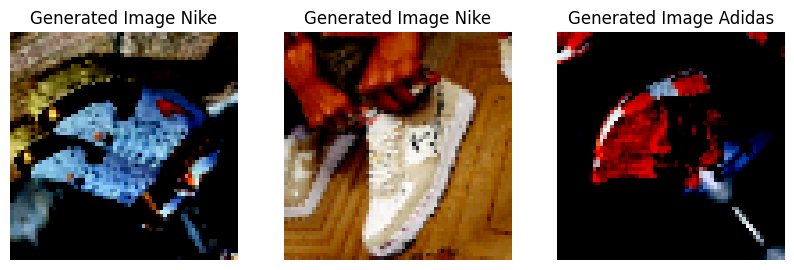

In [ ]:

print('New size of training set: '+str(augmented_images.shape))

brand_names = {
    0: 'Adidas',
    1: 'Converse',
    2: 'Nike'
}

plt.figure(figsize=(10, 4))
for i in range(3):
    # Access the generated image and its corresponding label
    j = np.random.randint(0, 99)
    gen_image = augmented_images[i+j]

    # Get the brand name
    brand_name = brand_names[augmented_labels[i+j]]

    # Plot the image
    plt.subplot(1, 3, i + 1)
    plt.imshow(gen_image)
    plt.title(f'Generated Image {brand_name}')
    plt.axis('off')

In [ ]:
augmented_labels = to_categorical(augmented_labels, num_classes=3)
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)
y_test_ag = to_categorical(y_test_ag, num_classes=3)

# Resnet50

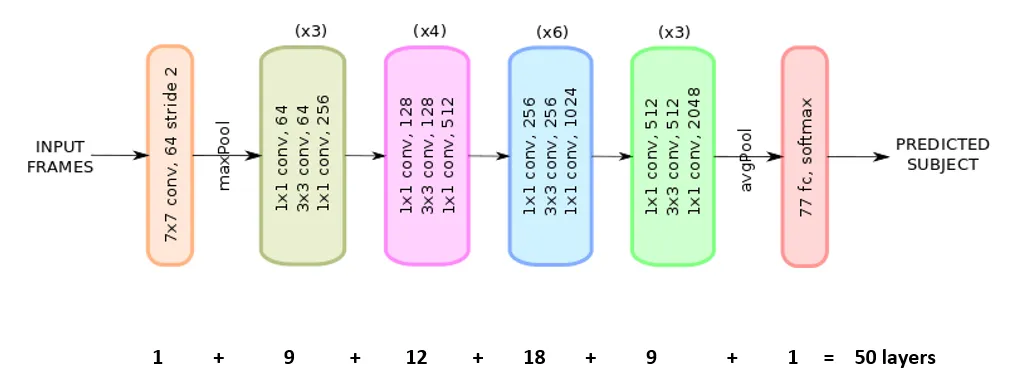

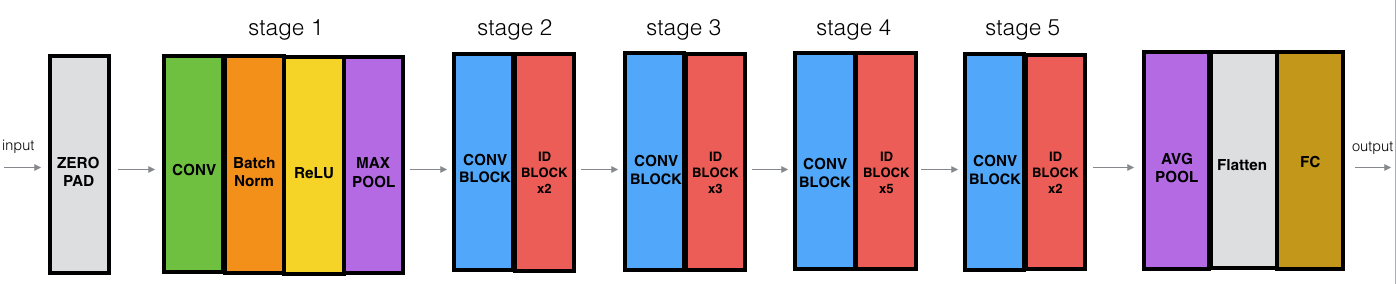

## Identity Block

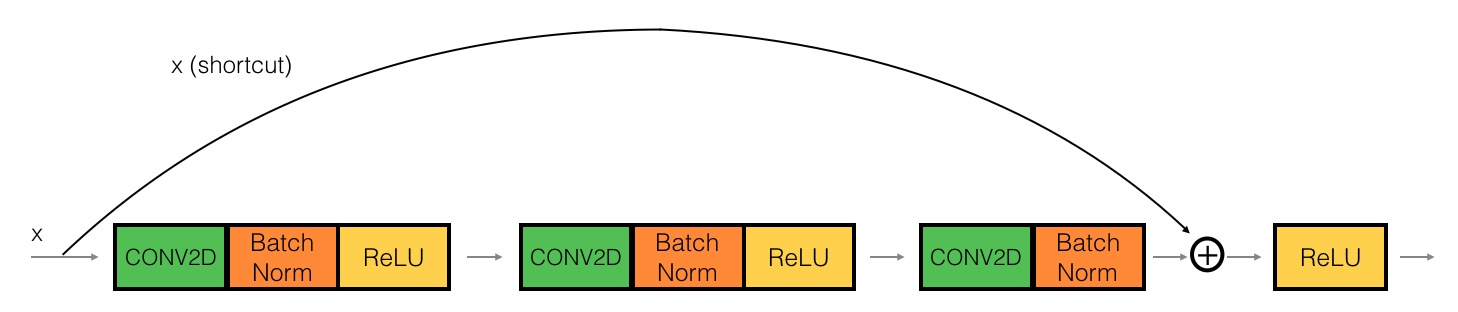

In [ ]:
def identity_block(X, f, filters, stage, block):
  """
    Implementation of the identity block as defined in Figure 3

    Arguments:
        X: input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
        f: integer, specifying the shape of the middle CONV's window for the main path
        filters: python list of integers, defining the number of filters in the CONV layers of the main path
        stage: integer, used to name the layers, depending on their position in the network
        block: string/character, used to name the layers, depending on their position in the network

    Returns:
        X: output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

  # defining name basis
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  # Retrieve Filters
  F1, F2, F3 = filters

  # Save the input value. You'll need this later to add back to the main path.
  X_shortcut = X

  """First component of main path"""
  # CONV2D
  X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
  # Batch Norm
  X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
  # ReLU
  X = Activation('relu')(X)

  """Second component of main path"""
  # CONV2D
  X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
  # Batch Norm
  X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
  # ReLU
  X = Activation('relu')(X)

  """Third component of main path"""
  # CONV2D
  X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
  # Batch Norm
  X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

  """Final step: Add shortcut value to main path, and pass it through a RELU activation"""
  # SKIP Connection
  X = Add()([X, X_shortcut])
  # ReLU
  X = Activation('relu')(X)

  return X




## Convolutional Block

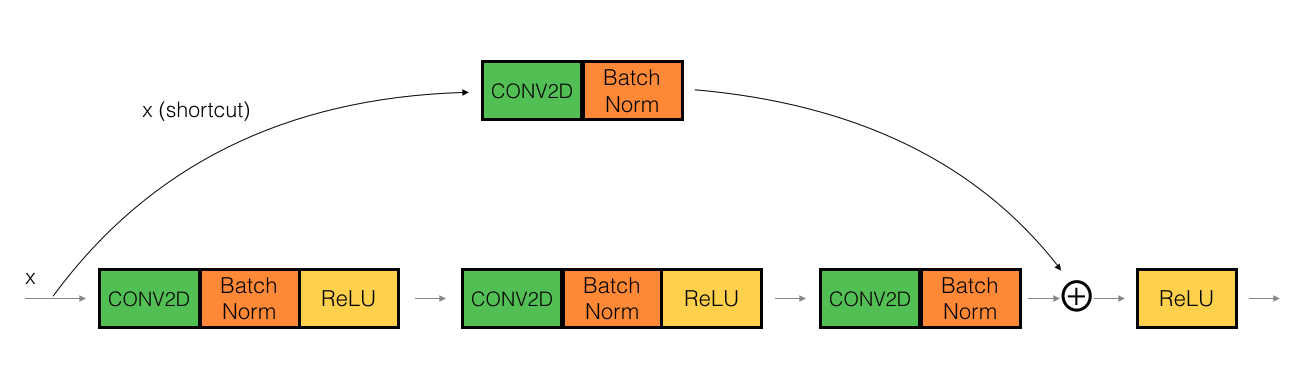

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):
  """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
        X: input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
        f: integer, specifying the shape of the middle CONV's window for the main path
        filters: python list of integers, defining the number of filters in the CONV layers of the main path
        stage: integer, used to name the layers, depending on their position in the network
        block: string/character, used to name the layers, depending on their position in the network
        s: Integer, specifying the stride to be used

    Returns:
        X: output of the convolutional block, tensor of shape (n_H, n_W, n_C)
  """

  # defining name basis
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  # Retrieve Filters
  F1, F2, F3 = filters

  # Save the input value
  X_shortcut = X

  """First component of main path"""
  # CONV2D
  X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
  # Batch Norm
  X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
  # ReLU
  X = Activation('relu')(X)

  """Second component of main path"""
  # CONV2D
  X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
  # Batch Norm
  X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
  # ReLU
  X = Activation('relu')(X)

  """Third component of main path"""
  # CONV2D
  X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
  # Batch Norm
  X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

  """Shortcut Path"""
  # Shortcut CONV2D
  X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
  # Shortcut Batch Norm
  X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

  """Final step: Add shortcut value to main path, and pass it through a RELU activation"""
  # Shortcut or Skip Connection
  X = Add()([X, X_shortcut])
  # ReLU
  X = Activation('relu')(X)

  return X

## Building Resnet50

In [ ]:
def ResNet50(input_shape = (64, 64, 3), classes = 3):
  """
    Implementation of the popular ResNet50 the following architecture:
        CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3 -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
        input_shape: shape of the images of the dataset
        classes: integer, number of classes

    Returns:
        model: a Model() instance in Keras
  """

  # Define the input as a tensor with shape input_shape
  X_input = Input(input_shape)

  # ZERO PAD
  X = ZeroPadding2D((3, 3))(X_input)


  """Stage 1"""
  # CONV
  X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
  # Batch Norm
  X = BatchNormalization(axis=3, name='bn_conv1')(X)
  # ReLU
  X = Activation('relu')(X)
  # MAX POOL
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)

  """Stage 2"""
  # CONV BLOCK
  X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
  # ID BLOCK x2
  X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
  X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')



  """Stage 3"""
  # CONV BLOCK
  X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
  # ID BLOCK x3
  X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
  X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
  X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')


  """Stage 4"""
  # CONV BLOCK
  X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
  # ID BLOCK x5
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')


  """Stage 5"""
  # CONV BLOCK
  X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
  # ID BLOCK x2
  X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
  X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

  # AVGPOOL. Use "X = AveragePooling2D(...)(X)"
  X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

  X = Flatten()(X)
  X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)

  model = tf.keras.models.Model(inputs = X_input, outputs = X, name='ResNet50')

  return model

In [ ]:
# from tensorflow.keras.metrics import categorical_accuracy,top_k_categorical_accuracy
# def top_5_accuracy(y_true, y_pred):
#     return top_k_categorical_accuracy(y_true, y_pred, k=5)

# Training Manual RESNET

In [ ]:
modelResnet1 = ResNet50(input_shape = (64, 64, 3), classes = 3)
modelResnet1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelResnet1.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 70, 70, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1 (Conv2D)              (None, 32, 32, 64)           9472      ['zero_padding2d[0][0]']      
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1[0][0]']        

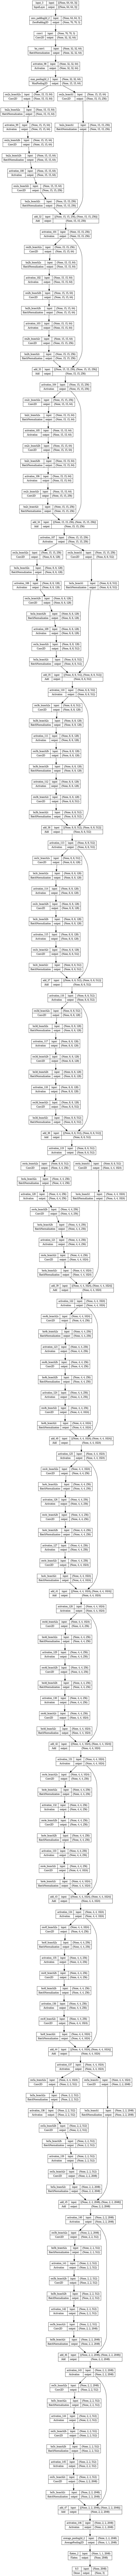

In [ ]:
tf.keras.utils.plot_model(modelResnet1, to_file='resnet50.png', show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy',verbose=0,patience=15)
#Early stopping to avoid overfitting of model

Without augmentation

In [ ]:
historyResnet = modelResnet1.fit(
  x_train, y_train,
  validation_data = (x_test,y_test),
  epochs=60,
  batch_size=50,
  callbacks= [early_stop],
  shuffle=True)

Epoch 1/60
10/10 [==============================] - 54s 702ms/step - loss: 3.2117 - accuracy: 0.3380 - val_loss: 62.7277 - val_accuracy: 0.3037
Epoch 2/60
10/10 [==============================] - 1s 86ms/step - loss: 1.6165 - accuracy: 0.3742 - val_loss: 8.3266 - val_accuracy: 0.3364
Epoch 3/60
10/10 [==============================] - 1s 80ms/step - loss: 1.5624 - accuracy: 0.4306 - val_loss: 1.3866 - val_accuracy: 0.3271
Epoch 4/60
10/10 [==============================] - 1s 87ms/step - loss: 1.5181 - accuracy: 0.5252 - val_loss: 1.1379 - val_accuracy: 0.3271
Epoch 5/60
10/10 [==============================] - 1s 80ms/step - loss: 0.9485 - accuracy: 0.7505 - val_loss: 1.1183 - val_accuracy: 0.3785
Epoch 6/60
10/10 [==============================] - 1s 87ms/step - loss: 0.5539 - accuracy: 0.8893 - val_loss: 1.1045 - val_accuracy: 0.3598
Epoch 7/60
10/10 [==============================] - 1s 86ms/step - loss: 0.9240 - accuracy: 0.8592 - val_loss: 1.2865 - val_accuracy: 0.3645
Epoch 8/60

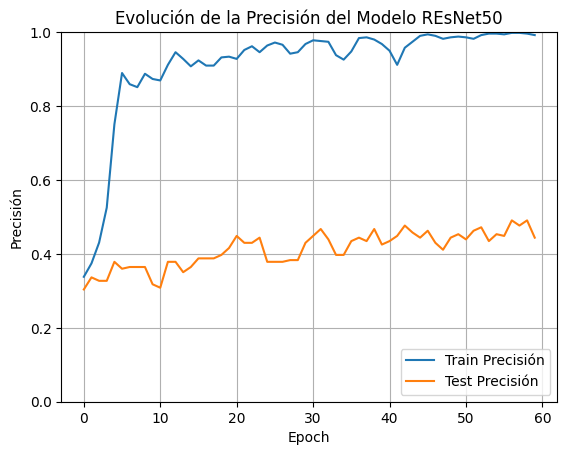

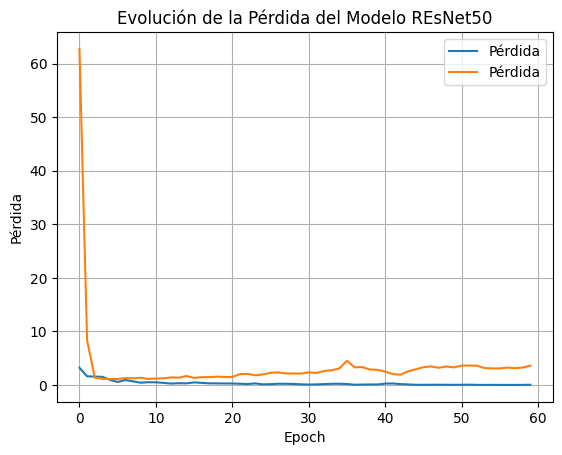

In [ ]:
fsbPlotModelTraining(historyResnet, inuModdelName='REsNet50')

7/7 [==============================] - 3s 130ms/step
              precision    recall  f1-score   support

           0       0.43      0.47      0.45        78
           1       0.43      0.39      0.41        70
           2       0.48      0.47      0.47        66

    accuracy                           0.44       214
   macro avg       0.45      0.44      0.44       214
weighted avg       0.44      0.44      0.44       214

[[37 24 17]
 [26 27 17]
 [23 12 31]]


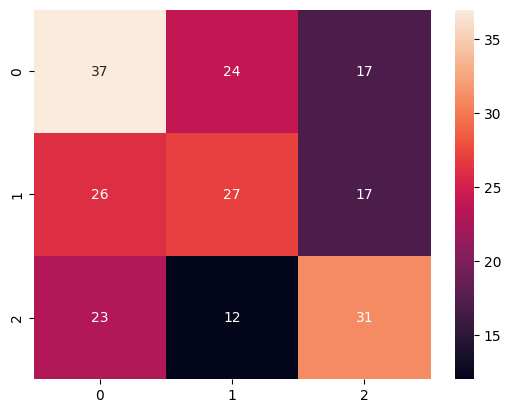

In [ ]:
fsbConfMatrix(modelo=modelResnet1,XVal=x_test,YVal=y_test)

In [ ]:
modelResnet1.save('Models/modelResnet1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


With augmented data

In [ ]:
modelResnet2 = ResNet50(input_shape = (64, 64, 3), classes = 3)
modelResnet2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelResnet2.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d_1 (ZeroPadd  (None, 70, 70, 3)            0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1 (Conv2D)              (None, 32, 32, 64)           9472      ['zero_padding2d_1[0][0]']    
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1[0][0]']        

In [ ]:
history2_res = modelResnet2.fit(
  augmented_images, augmented_labels,
  validation_data = (x_test_ag,y_test_ag),
  epochs=60,
  batch_size=50,
  callbacks= [early_stop],
  shuffle=True)

Epoch 1/60
30/30 [==============================] - 40s 264ms/step - loss: 2.2460 - accuracy: 0.3441 - val_loss: 1.1385 - val_accuracy: 0.3645
Epoch 2/60
30/30 [==============================] - 2s 83ms/step - loss: 1.2930 - accuracy: 0.3689 - val_loss: 1.1099 - val_accuracy: 0.3645
Epoch 3/60
30/30 [==============================] - 2s 80ms/step - loss: 1.2396 - accuracy: 0.4574 - val_loss: 3.5483 - val_accuracy: 0.3660
Epoch 4/60
30/30 [==============================] - 2s 77ms/step - loss: 1.3515 - accuracy: 0.3843 - val_loss: 2.7656 - val_accuracy: 0.3692
Epoch 5/60
30/30 [==============================] - 2s 80ms/step - loss: 1.2141 - accuracy: 0.3595 - val_loss: 1.1381 - val_accuracy: 0.3349
Epoch 6/60
30/30 [==============================] - 2s 83ms/step - loss: 1.4657 - accuracy: 0.4011 - val_loss: 8.7609 - val_accuracy: 0.3302
Epoch 7/60
30/30 [==============================] - 2s 79ms/step - loss: 1.1791 - accuracy: 0.3722 - val_loss: 3.6919 - val_accuracy: 0.3411
Epoch 8/60


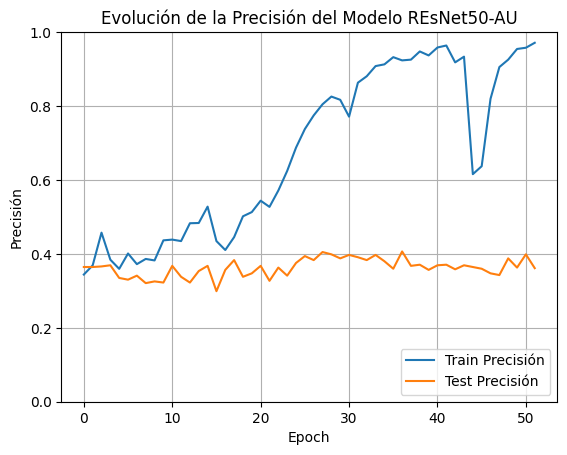

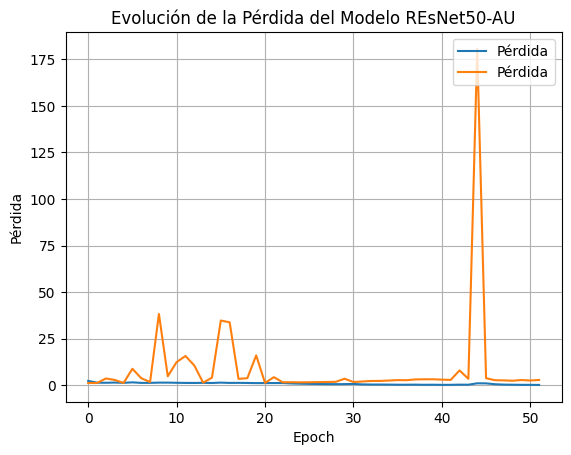

In [ ]:
fsbPlotModelTraining(history2_res, inuModdelName='REsNet50-AU')

21/21 [==============================] - 2s 54ms/step
              precision    recall  f1-score   support

           0       0.39      0.38      0.39       234
           1       0.34      0.36      0.35       210
           2       0.35      0.33      0.34       198

    accuracy                           0.36       642
   macro avg       0.36      0.36      0.36       642
weighted avg       0.36      0.36      0.36       642

[[90 72 72]
 [81 76 53]
 [59 73 66]]


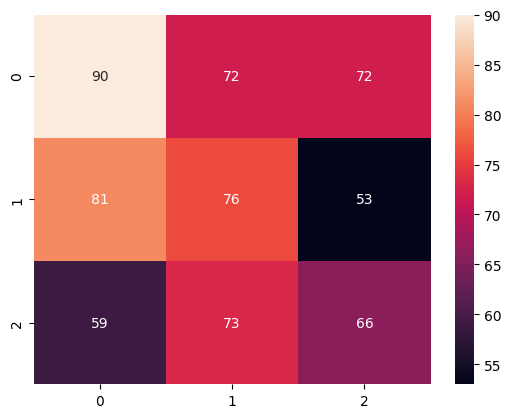

In [ ]:
fsbConfMatrix(modelo=modelResnet2,XVal=x_test_ag,YVal=y_test_ag)

In [ ]:
modelResnet2.save('Models/modelResnet2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# RESNET transfer Learning

In [ ]:
def nuRESNET ():

    # Download RESNET without the Dense layer
    Res_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64,64,3))

    x = Res_model.output
    x = GlobalAveragePooling2D()(x)

    # Add Dense layers
    x = Dense(128, activation='relu')(x)

    predictions = Dense(3, activation='softmax')(x)

    model = Model(inputs=Res_model.input, outputs=predictions)

    # Freeze all Inception layers
    for layer in Res_model.layers:
        layer.trainable = False

    return model

In [ ]:
modelRes = nuRESNET()

# Compile the model
modelRes.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
modelRes.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                         

In [ ]:
early_stop = EarlyStopping(monitor='val_accuracy',patience=15)

In [ ]:
#tf.config.run_functions_eagerly(True)
historyTres = modelRes.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=60,
                    batch_size=50,
                    callbacks = [early_stop])

Epoch 1/60
10/10 [==============================] - 6s 242ms/step - loss: 1.1695 - accuracy: 0.3260 - val_loss: 1.0977 - val_accuracy: 0.3785
Epoch 2/60
10/10 [==============================] - 0s 35ms/step - loss: 1.0503 - accuracy: 0.4427 - val_loss: 1.0617 - val_accuracy: 0.4206
Epoch 3/60
10/10 [==============================] - 0s 41ms/step - loss: 1.0157 - accuracy: 0.5030 - val_loss: 1.0436 - val_accuracy: 0.4439
Epoch 4/60
10/10 [==============================] - 0s 39ms/step - loss: 0.9778 - accuracy: 0.5312 - val_loss: 1.0309 - val_accuracy: 0.4766
Epoch 5/60
10/10 [==============================] - 0s 31ms/step - loss: 0.9504 - accuracy: 0.5553 - val_loss: 1.0133 - val_accuracy: 0.4907
Epoch 6/60
10/10 [==============================] - 0s 31ms/step - loss: 0.9369 - accuracy: 0.5594 - val_loss: 1.0129 - val_accuracy: 0.5047
Epoch 7/60
10/10 [==============================] - 0s 39ms/step - loss: 0.8951 - accuracy: 0.6237 - val_loss: 1.0016 - val_accuracy: 0.5187
Epoch 8/60
1

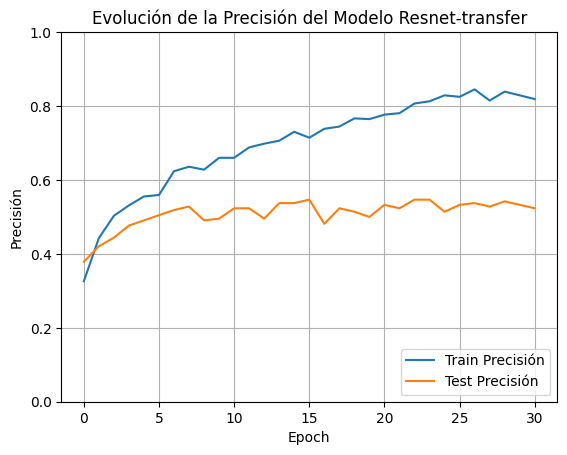

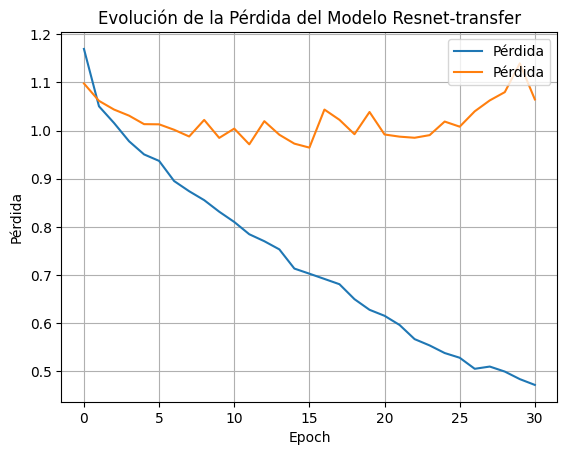

In [ ]:
fsbPlotModelTraining(historyTres, inuModdelName='Resnet-transfer')

7/7 [==============================] - 1s 46ms/step
              precision    recall  f1-score   support

           0       0.49      0.64      0.55        78
           1       0.48      0.31      0.38        70
           2       0.62      0.61      0.61        66

    accuracy                           0.52       214
   macro avg       0.53      0.52      0.51       214
weighted avg       0.52      0.52      0.51       214

[[50 16 12]
 [35 22 13]
 [18  8 40]]


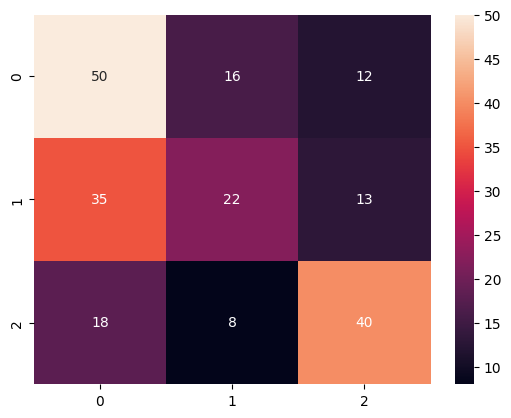

In [ ]:
fsbConfMatrix(modelo=modelRes,XVal=x_test,YVal=y_test)

In [ ]:
modelRes.save('Models/modelResTran1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


With augmented data

In [ ]:
modelResAU = nuRESNET()

# Compile the model
modelResAU.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
modelResAU.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
#tf.config.run_functions_eagerly(True)
historyTres_AU = modelResAU.fit(augmented_images, augmented_labels,
                    validation_data = (x_test_ag,y_test_ag),
                    epochs=60,
                    batch_size=50,
                    callbacks = [early_stop])

Epoch 1/60
30/30 [==============================] - 6s 86ms/step - loss: 1.1267 - accuracy: 0.3716 - val_loss: 1.0859 - val_accuracy: 0.4143
Epoch 2/60
30/30 [==============================] - 1s 27ms/step - loss: 1.0651 - accuracy: 0.4111 - val_loss: 1.1168 - val_accuracy: 0.4019
Epoch 3/60
30/30 [==============================] - 1s 30ms/step - loss: 1.0415 - accuracy: 0.4561 - val_loss: 1.1048 - val_accuracy: 0.3785
Epoch 4/60
30/30 [==============================] - 1s 28ms/step - loss: 1.0319 - accuracy: 0.4520 - val_loss: 1.0872 - val_accuracy: 0.4237
Epoch 5/60
30/30 [==============================] - 1s 31ms/step - loss: 1.0110 - accuracy: 0.4769 - val_loss: 1.1051 - val_accuracy: 0.4206
Epoch 6/60
30/30 [==============================] - 1s 30ms/step - loss: 0.9871 - accuracy: 0.5117 - val_loss: 1.1139 - val_accuracy: 0.4034
Epoch 7/60
30/30 [==============================] - 1s 32ms/step - loss: 0.9679 - accuracy: 0.5245 - val_loss: 1.0935 - val_accuracy: 0.4206
Epoch 8/60
30

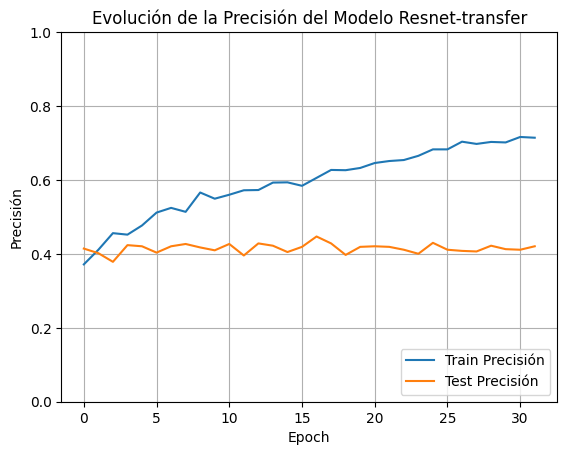

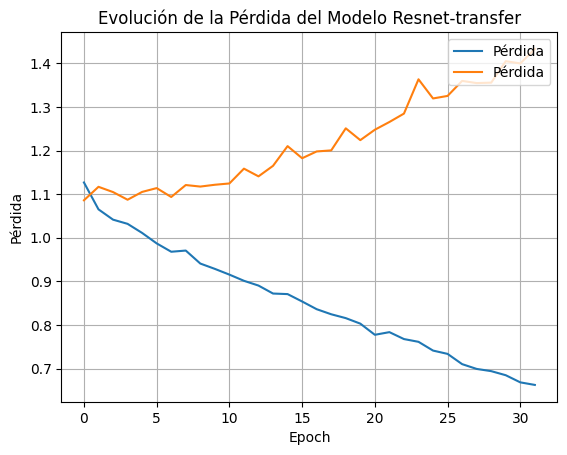

In [ ]:
fsbPlotModelTraining(historyTres_AU, inuModdelName='Resnet-transfer')

21/21 [==============================] - 1s 26ms/step
              precision    recall  f1-score   support

           0       0.44      0.30      0.36       234
           1       0.42      0.43      0.43       210
           2       0.40      0.55      0.47       198

    accuracy                           0.42       642
   macro avg       0.42      0.43      0.42       642
weighted avg       0.43      0.42      0.41       642

[[ 71  75  88]
 [ 47  90  73]
 [ 42  47 109]]


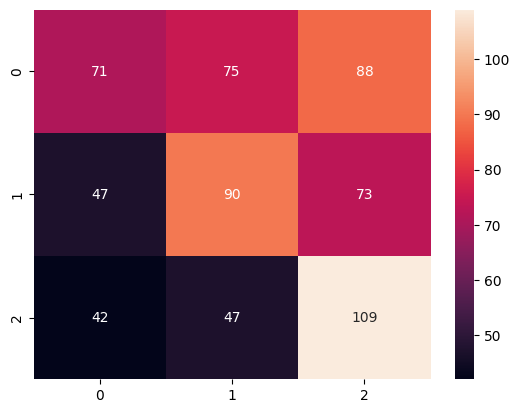

In [ ]:
fsbConfMatrix(modelo=modelResAU,XVal=x_test_ag,YVal=y_test_ag)

In [ ]:
modelResAU.save('Models/modelResTran2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# SE_Resnet

## Squeeze and Excitation Block

In [ ]:
def se_block(tensor):

    x = GlobalAveragePooling2D()(tensor)
    x2 = Dense(x.shape[1]//8, activation='relu')(x)
    x2 = Dense(x.shape[1], activation='sigmoid')(x2)
    x2 = tf.keras.layers.Reshape((1,1,x.shape[1]), input_shape=(x.shape[1],))(x2)
    x = tf.keras.layers.multiply((x2,tensor))

    return x

## Building SE-Resnet50

In [ ]:
def SeResNet50(input_shape = (64, 64, 3), classes = 3):
  """
    Implementation of the popular ResNet50 the following architecture:
        CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3 -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
        input_shape: shape of the images of the dataset
        classes: integer, number of classes

    Returns:
        model: a Model() instance in Keras
  """

  # Define the input as a tensor with shape input_shape
  X_input = Input(input_shape)

  # ZERO PAD
  X = ZeroPadding2D((3, 3))(X_input)


  """Stage 1"""
  # CONV
  X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
  # Batch Norm
  X = BatchNormalization(axis=3, name='bn_conv1')(X)
  # ReLU
  X = Activation('relu')(X)
  # MAX POOL
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)

  """Stage 2"""
  # CONV BLOCK
  X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
  # ID BLOCK x2
  X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
  X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
  # SE BLOCK
  X = se_block(X)



  """Stage 3"""
  # CONV BLOCK
  X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
  # ID BLOCK x3
  X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
  X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
  X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
  # SE BLOCK
  X = se_block(X)

  """Stage 4"""
  # CONV BLOCK
  X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
  # ID BLOCK x5
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
  # SE BLOCK
  X = se_block(X)


  """Stage 5"""
  # CONV BLOCK
  X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
  # ID BLOCK x2
  X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
  X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')



  # AVGPOOL. Use "X = AveragePooling2D(...)(X)"
  #X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
  X = GlobalAveragePooling2D()(X)

  #X = Flatten()(X)
  X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)

  model = tf.keras.models.Model(inputs = X_input, outputs = X, name='ResNet50')

  return model

## Training SE-ResNet

In [ ]:
model_SeRes = SeResNet50(input_shape = (64, 64, 3), classes = 3)
model_SeRes.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_SeRes.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 70, 70, 3)            0         ['input_5[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1 (Conv2D)              (None, 32, 32, 64)           9472      ['zero_padding2d_2[0][0]']    
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1[0][0]']        

In [ ]:
early_stop = EarlyStopping(monitor='val_accuracy',patience=15)

Without augmeted data

In [ ]:
#tf.config.run_functions_eagerly(True)
historySeResNet = model_SeRes.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=60,
                    batch_size=50,
                    callbacks = [early_stop])

Epoch 1/60
10/10 [==============================] - 37s 216ms/step - loss: 3.9470 - accuracy: 0.3119 - val_loss: 1.1134 - val_accuracy: 0.3084
Epoch 2/60
10/10 [==============================] - 1s 95ms/step - loss: 1.3439 - accuracy: 0.3300 - val_loss: 1.1231 - val_accuracy: 0.3271
Epoch 3/60
10/10 [==============================] - 1s 88ms/step - loss: 1.2762 - accuracy: 0.3903 - val_loss: 1.1209 - val_accuracy: 0.3271
Epoch 4/60
10/10 [==============================] - 1s 88ms/step - loss: 1.3021 - accuracy: 0.4990 - val_loss: 1.1234 - val_accuracy: 0.3271
Epoch 5/60
10/10 [==============================] - 1s 94ms/step - loss: 1.0993 - accuracy: 0.5614 - val_loss: 1.1014 - val_accuracy: 0.3084
Epoch 6/60
10/10 [==============================] - 1s 89ms/step - loss: 1.0561 - accuracy: 0.7143 - val_loss: 1.1143 - val_accuracy: 0.3598
Epoch 7/60
10/10 [==============================] - 1s 89ms/step - loss: 0.7426 - accuracy: 0.7948 - val_loss: 1.1040 - val_accuracy: 0.3318
Epoch 8/60


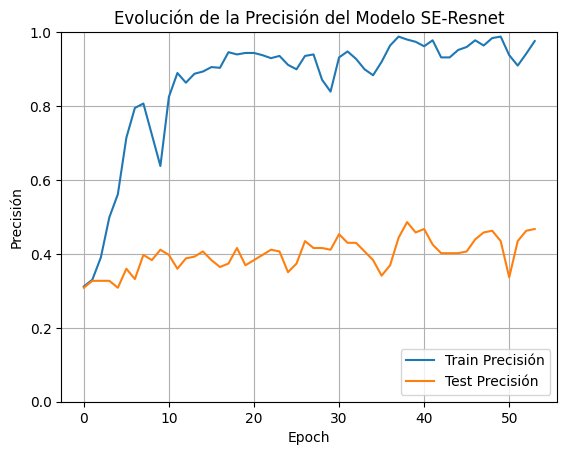

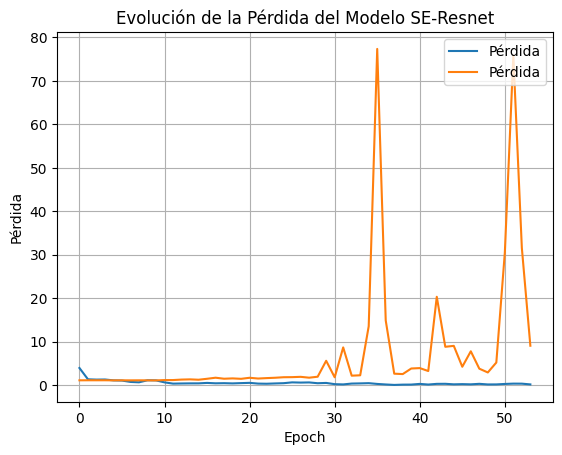

In [ ]:
fsbPlotModelTraining(historySeResNet, inuModdelName='SE-Resnet')

7/7 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.49      0.44      0.46        78
           1       0.44      0.51      0.47        70
           2       0.48      0.45      0.47        66

    accuracy                           0.47       214
   macro avg       0.47      0.47      0.47       214
weighted avg       0.47      0.47      0.47       214

[[34 27 17]
 [18 36 16]
 [17 19 30]]


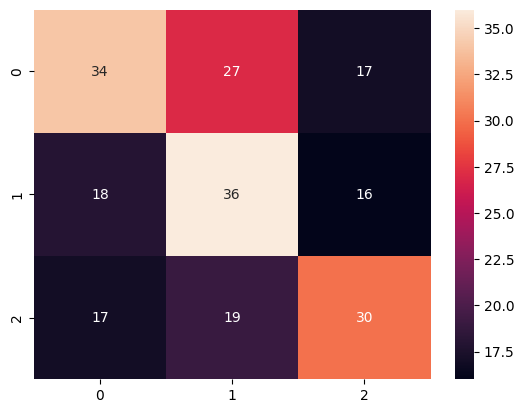

In [ ]:
fsbConfMatrix(modelo=model_SeRes,XVal=x_test,YVal=y_test)

In [ ]:
model_SeRes.save('Models/modelResSE1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


With augmented data

In [ ]:
model2_SeRes = SeResNet50(input_shape = (64, 64, 3), classes = 3)
model2_SeRes.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2_SeRes.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d_3 (ZeroPadd  (None, 70, 70, 3)            0         ['input_6[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1 (Conv2D)              (None, 32, 32, 64)           9472      ['zero_padding2d_3[0][0]']    
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1[0][0]']        

In [ ]:
#tf.config.run_functions_eagerly(True)
historySeResNet2 = model2_SeRes.fit(augmented_images, augmented_labels,
                    validation_data=(x_test_ag, y_test_ag),
                    epochs=60,
                    batch_size=50,
                    callbacks = [early_stop])

Epoch 1/60
30/30 [==============================] - 39s 129ms/step - loss: 2.1678 - accuracy: 0.3521 - val_loss: 1.1024 - val_accuracy: 0.3645
Epoch 2/60
30/30 [==============================] - 2s 83ms/step - loss: 1.3539 - accuracy: 0.3716 - val_loss: 1.0973 - val_accuracy: 0.3302
Epoch 3/60
30/30 [==============================] - 2s 81ms/step - loss: 1.3089 - accuracy: 0.3903 - val_loss: 1.1508 - val_accuracy: 0.3084
Epoch 4/60
30/30 [==============================] - 2s 79ms/step - loss: 1.5040 - accuracy: 0.3696 - val_loss: 1.4053 - val_accuracy: 0.3318
Epoch 5/60
30/30 [==============================] - 2s 83ms/step - loss: 1.2165 - accuracy: 0.3575 - val_loss: 1.4505 - val_accuracy: 0.3224
Epoch 6/60
30/30 [==============================] - 3s 87ms/step - loss: 1.2826 - accuracy: 0.4138 - val_loss: 1.1789 - val_accuracy: 0.3287
Epoch 7/60
30/30 [==============================] - 2s 82ms/step - loss: 1.4945 - accuracy: 0.3535 - val_loss: 1.2338 - val_accuracy: 0.3271
Epoch 8/60


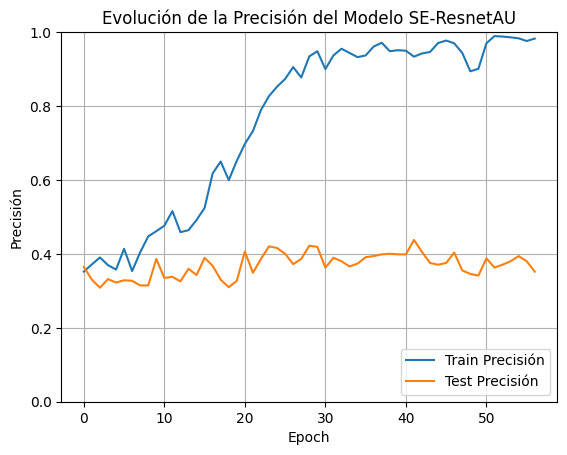

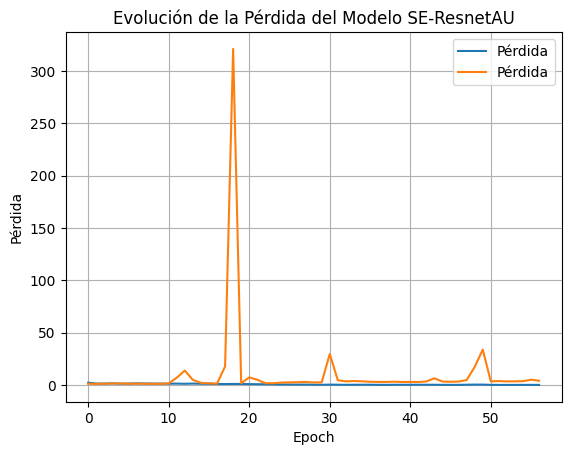

In [ ]:
fsbPlotModelTraining(historySeResNet2, inuModdelName='SE-ResnetAU')

21/21 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

           0       0.38      0.18      0.25       234
           1       0.35      0.49      0.41       210
           2       0.34      0.41      0.37       198

    accuracy                           0.35       642
   macro avg       0.36      0.36      0.34       642
weighted avg       0.36      0.35      0.34       642

[[ 43 102  89]
 [ 40 102  68]
 [ 31  86  81]]


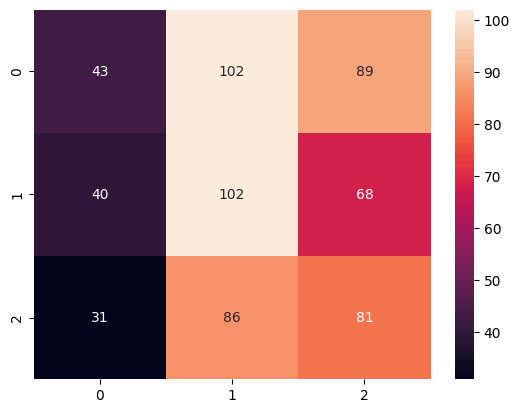

In [ ]:
fsbConfMatrix(modelo=model2_SeRes,XVal=x_test_ag,YVal=y_test_ag)

In [ ]:
model2_SeRes.save('Models/modelResSE2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## SE-Resnet Transfer Learning

In [ ]:
def build_resnet_stages(input_shape, classes):
    # Load the pre-trained ResNet50 model without the top layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the original layers
    for layer in base_model.layers:
        layer.trainable = False

    # Define stage boundaries
    stages = [
        'conv2_block3_out',   # End of stage 2 (conv2_x)
        'conv3_block4_out',   # End of stage 3 (conv3_x)
        'conv4_block6_out',   # End of stage 4 (conv4_x)
        'conv5_block3_out'    # End of stage 5 (conv5_x)
    ]

    # Create a list to store models for each stage
    stage_models = []

    # Iterate through the stages and build models for each stage
    prev_output = base_model.input
    for stage_name in stages:
        # Get the output tensor of the current stage
        output_tensor = base_model.get_layer(stage_name).output

        stage_model = Model(inputs=prev_output, outputs=output_tensor)

        # Update the previous output for the next stage
        prev_output = output_tensor

        # Add the model to the list
        stage_models.append(stage_model)


    return stage_models

In [ ]:
def assemble_resnet_with_se(stages, input_shape, classes):
    # Define input tensor
    input_tensor = Input(shape=input_shape)

    # Initialize previous output tensor
    prev_output = input_tensor

    # Iterate through the stages and assemble them with SE blocks
    for stage_model in stages:
        # Call the stage model with the previous output tensor
        output_tensor = stage_model(prev_output)

        # Add SE block after each stage model but the last one
        if stage_model != stages[-1]:
          output_tensor = se_block(output_tensor)

        # Update the previous output tensor for the next stage
        prev_output = output_tensor

    # Global average pooling and classification layers
    x = GlobalAveragePooling2D()(output_tensor)
    x = Dense(classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=input_tensor, outputs=x)

    return model

In [ ]:
# Define input shape and number of classes
input_shape = (64, 64, 3)
classes = 3  # Example number of classes

# Build models for each stage
stages = build_resnet_stages(input_shape, classes)

# Assemble ResNet with SE blocks
resnet_with_se = assemble_resnet_with_se(stages, input_shape, classes)

# Print model summary
resnet_with_se.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 model_2 (Functional)        (None, 16, 16, 256)          229760    ['input_11[0][0]']            
                                                                                                  
 global_average_pooling2d_1  (None, 256)                  0         ['model_2[0][0]']             
 0 (GlobalAveragePooling2D)                                                                       
                                                                                                  
 dense_16 (Dense)            (None, 32)                   8224      ['global_average_pooling

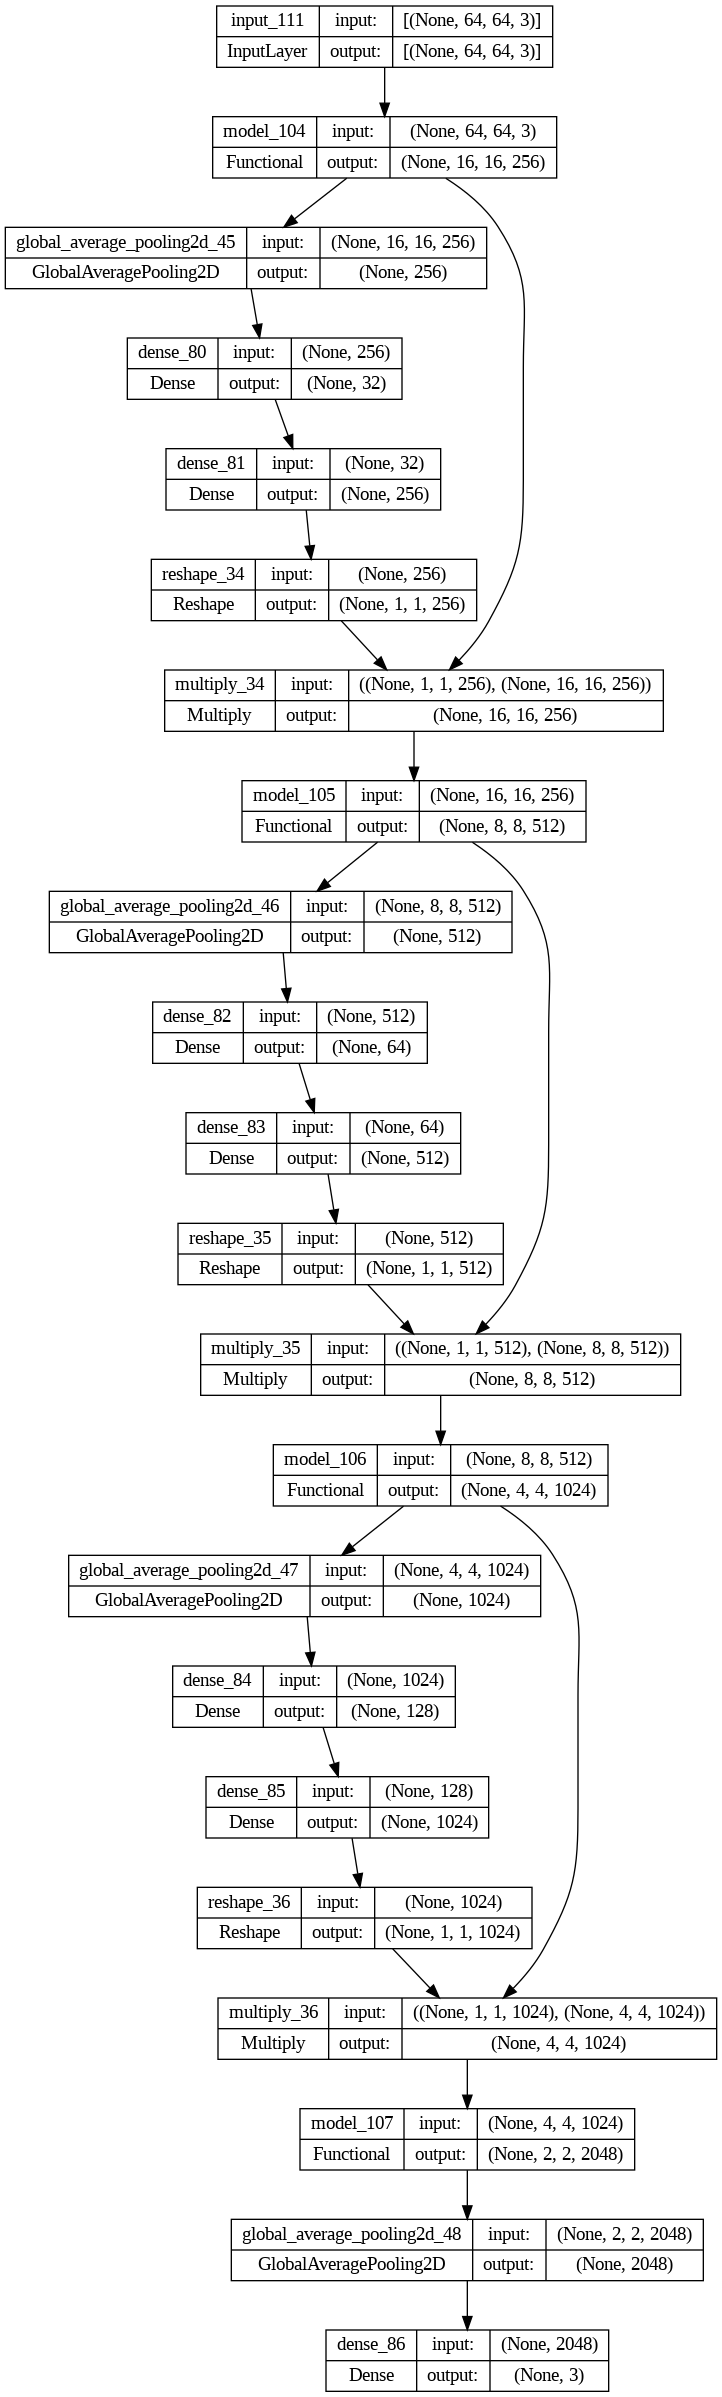

In [ ]:
tf.keras.utils.plot_model(resnet_with_se, to_file='resnet50with_SE.png', show_shapes=True)

In [ ]:
# Compile the model
resnet_with_se.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#tf.config.run_functions_eagerly(True)
historyTresSE = resnet_with_se.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=60,
                    batch_size=50,
                    callbacks = [early_stop])

Epoch 1/60
10/10 [==============================] - 8s 200ms/step - loss: 1.1079 - accuracy: 0.3461 - val_loss: 1.1184 - val_accuracy: 0.3084
Epoch 2/60
10/10 [==============================] - 1s 58ms/step - loss: 1.1092 - accuracy: 0.3400 - val_loss: 1.0996 - val_accuracy: 0.3645
Epoch 3/60
10/10 [==============================] - 1s 52ms/step - loss: 1.1106 - accuracy: 0.3038 - val_loss: 1.1072 - val_accuracy: 0.3084
Epoch 4/60
10/10 [==============================] - 1s 59ms/step - loss: 1.1015 - accuracy: 0.3099 - val_loss: 1.0933 - val_accuracy: 0.3692
Epoch 5/60
10/10 [==============================] - 1s 52ms/step - loss: 1.0929 - accuracy: 0.3581 - val_loss: 1.1040 - val_accuracy: 0.3178
Epoch 6/60
10/10 [==============================] - 1s 52ms/step - loss: 1.0912 - accuracy: 0.4004 - val_loss: 1.0931 - val_accuracy: 0.3738
Epoch 7/60
10/10 [==============================] - 1s 52ms/step - loss: 1.0850 - accuracy: 0.4165 - val_loss: 1.0875 - val_accuracy: 0.3551
Epoch 8/60
1

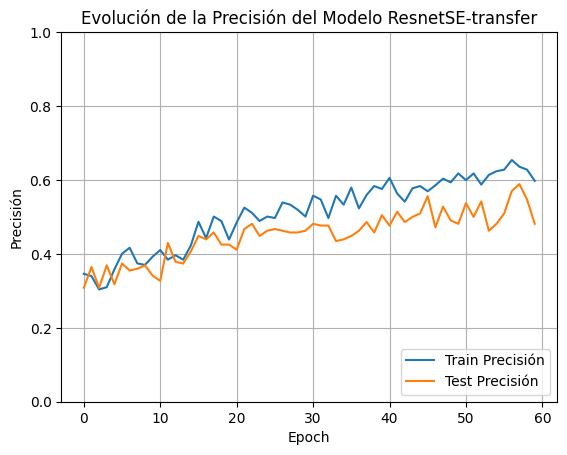

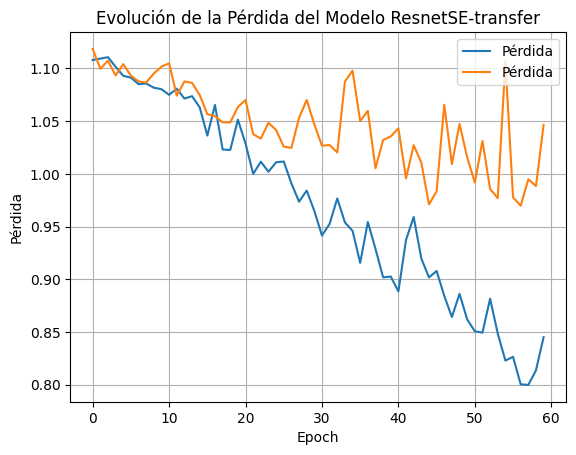

In [ ]:
fsbPlotModelTraining(historyTresSE, inuModdelName='ResnetSE-transfer')

7/7 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.48      0.47      0.48        78
           1       0.89      0.23      0.36        70
           2       0.42      0.76      0.54        66

    accuracy                           0.48       214
   macro avg       0.60      0.49      0.46       214
weighted avg       0.60      0.48      0.46       214

[[37  2 39]
 [24 16 30]
 [16  0 50]]


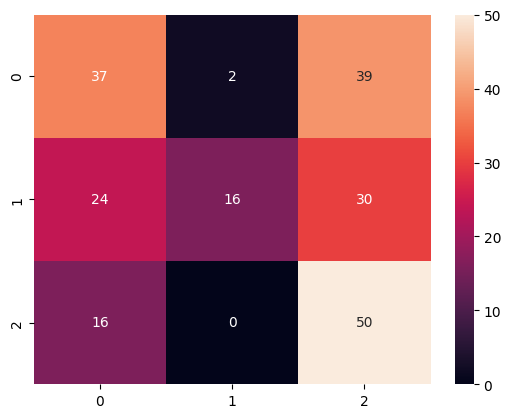

In [ ]:
fsbConfMatrix(modelo=resnet_with_se,XVal=x_test,YVal=y_test)

In [ ]:
resnet_with_se.save('Models/modelResSET1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


With augmented data

In [ ]:
# Build models for each stage
stages = build_resnet_stages(input_shape, classes)

# Assemble ResNet with SE blocks
resnet_with_seAU = assemble_resnet_with_se(stages, input_shape, classes)
resnet_with_seAU.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 model_7 (Functional)        (None, 16, 16, 256)          229760    ['input_16[0][0]']            
                                                                                                  
 global_average_pooling2d_1  (None, 256)                  0         ['model_7[0][0]']             
 4 (GlobalAveragePooling2D)                                                                       
                                                                                                  
 dense_23 (Dense)            (None, 32)                   8224      ['global_average_poolin

In [ ]:
# Compile the model
resnet_with_seAU.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
historyTresSE_AU = resnet_with_seAU.fit(augmented_images, augmented_labels,
                    validation_data = (x_test_ag,y_test_ag),
                    epochs=60,
                    batch_size=50,
                    callbacks = [early_stop])

Epoch 1/60
30/30 [==============================] - 10s 141ms/step - loss: 1.1067 - accuracy: 0.3474 - val_loss: 1.0984 - val_accuracy: 0.3614
Epoch 2/60
30/30 [==============================] - 3s 88ms/step - loss: 1.1013 - accuracy: 0.3407 - val_loss: 1.0956 - val_accuracy: 0.3910
Epoch 3/60
30/30 [==============================] - 2s 56ms/step - loss: 1.0968 - accuracy: 0.3461 - val_loss: 1.0983 - val_accuracy: 0.3302
Epoch 4/60
30/30 [==============================] - 1s 49ms/step - loss: 1.0970 - accuracy: 0.3514 - val_loss: 1.1052 - val_accuracy: 0.3458
Epoch 5/60
30/30 [==============================] - 1s 50ms/step - loss: 1.0994 - accuracy: 0.3575 - val_loss: 1.0963 - val_accuracy: 0.3318
Epoch 6/60
30/30 [==============================] - 1s 49ms/step - loss: 1.1009 - accuracy: 0.3273 - val_loss: 1.0958 - val_accuracy: 0.3832
Epoch 7/60
30/30 [==============================] - 1s 49ms/step - loss: 1.1017 - accuracy: 0.3461 - val_loss: 1.1003 - val_accuracy: 0.3271
Epoch 8/60


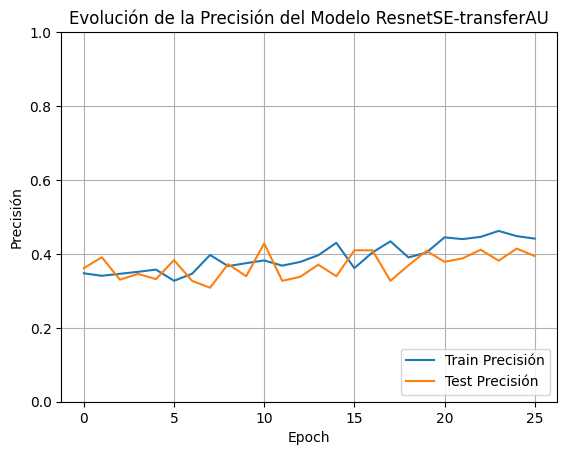

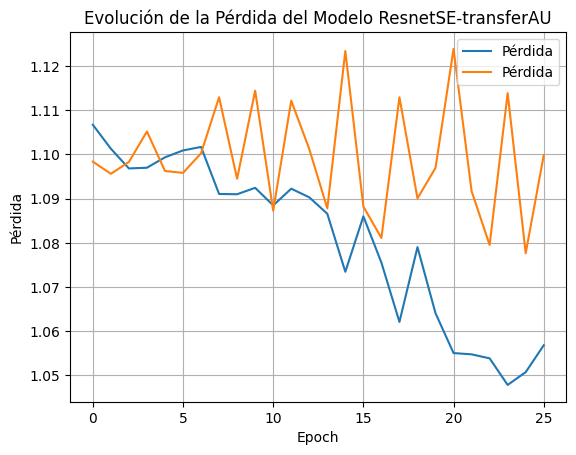

In [ ]:
fsbPlotModelTraining(historyTresSE_AU, inuModdelName='ResnetSE-transferAU')

21/21 [==============================] - 2s 18ms/step
              precision    recall  f1-score   support

           0       0.40      0.67      0.50       234
           1       0.53      0.05      0.09       210
           2       0.37      0.43      0.40       198

    accuracy                           0.39       642
   macro avg       0.43      0.38      0.33       642
weighted avg       0.43      0.39      0.34       642

[[157   7  70]
 [122  10  78]
 [110   2  86]]


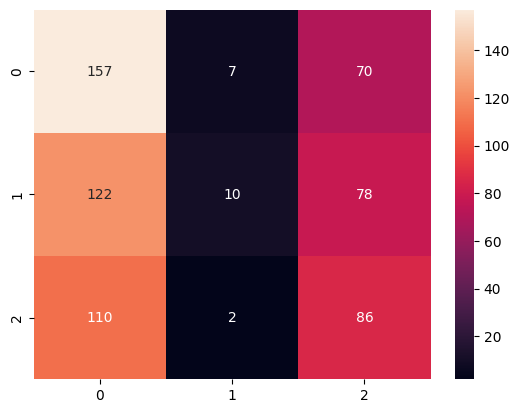

In [ ]:
fsbConfMatrix(modelo=resnet_with_seAU,XVal=x_test_ag,YVal=y_test_ag)

In [ ]:
resnet_with_seAU.save('Models/modelResSET2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
!unzip /content/drive/MyDrive/Colab_Notebooks/Project_2/Models.zip

Archive:  /content/drive/MyDrive/Colab_Notebooks/Project_2/Models.zip
   creating: content/Models/
  inflating: content/Models/modelResTran2.h5  
  inflating: content/Models/modelResSET1.h5  
  inflating: content/Models/modelResSE1.h5  
  inflating: content/Models/modelResnet2.h5  
  inflating: content/Models/modelResSET2.h5  
  inflating: content/Models/modelResSE2.h5  
  inflating: content/Models/modelResTran1.h5  
   creating: content/Models/.ipynb_checkpoints/
  inflating: content/Models/modelResnet1.h5  


# Grad-CAM

## SE-Resnet50

In [6]:
from tensorflow.keras.models import load_model

In [154]:
modelResnet1 = load_model('/content/content/Models/modelResSE1.h5')

In [155]:
modelResnet1.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 70, 70, 3)            0         ['input_9[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1 (Conv2D)              (None, 32, 32, 64)           9472      ['zero_padding2d_4[0][0]']    
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1[0][0]']        

In [167]:
print(x_test[1].shape)
pred_cam = modelResnet1.predict(x_test[0].reshape(1,64,64,3))

print(np.argmax(pred_cam[0]))

(64, 64, 3)
1/1 [==============================] - 0s 40ms/step
1


In [168]:
#output_cam = model.output[:,0]
last_conv_layer = modelResnet1.get_layer('activation_244')

In [169]:
last_conv_layer_model = tf.keras.Model(modelResnet1.inputs, last_conv_layer.output)

In [170]:
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in ["global_average_pooling2d_7", "fc3"]:
    x = modelResnet1.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

In [171]:
with tf.GradientTape() as tape:
    inputs = x_test[1]
    inputs = tf.expand_dims(inputs, 0)
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:,top_pred_index]

In [172]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [173]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

In [174]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [175]:
# Average over all the filters to get a single 2D array
gradcam = np.mean(last_conv_layer_output, axis=-1)
# Clip the values (equivalent to applying ReLU)
# and then normalise the values
gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
gradcam = cv2.resize(gradcam, (64, 64))

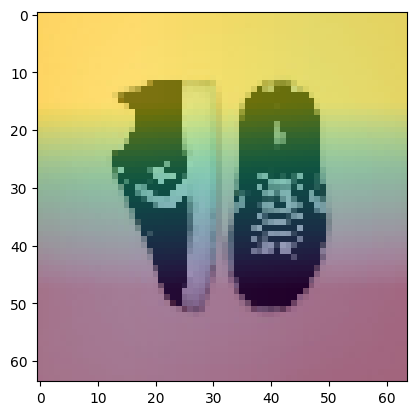

In [176]:
plt.imshow(x_test[1])
plt.imshow(gradcam, alpha=0.5)

## Resnet50

In [177]:
modelResnet1 = load_model('/content/content/Models/modelResTran2.h5')

In [178]:
modelResnet1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [179]:
print(x_test[1].shape)
pred_cam = modelResnet1.predict(x_test[0].reshape(1,64,64,3))

print(np.argmax(pred_cam[0]))

(64, 64, 3)
1/1 [==============================] - 2s 2s/step
0


In [181]:
#output_cam = model.output[:,0]
last_conv_layer = modelResnet1.get_layer('conv5_block3_out')

In [182]:
last_conv_layer_model = tf.keras.Model(modelResnet1.inputs, last_conv_layer.output)

In [184]:
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in ["global_average_pooling2d_3", "dense_6"]:
    x = modelResnet1.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

In [185]:
with tf.GradientTape() as tape:
    inputs = x_test[1]
    inputs = tf.expand_dims(inputs, 0)
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:,top_pred_index]

In [186]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [187]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

In [188]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [189]:
# Average over all the filters to get a single 2D array
gradcam = np.mean(last_conv_layer_output, axis=-1)
# Clip the values (equivalent to applying ReLU)
# and then normalise the values
gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
gradcam = cv2.resize(gradcam, (64, 64))

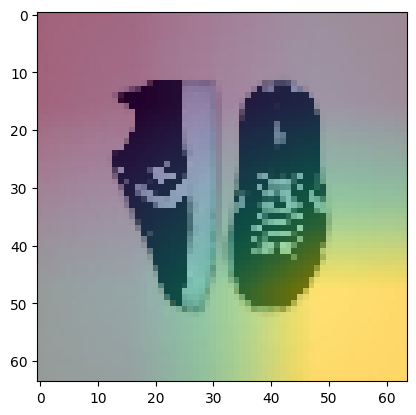

In [190]:
plt.imshow(x_test[1])
plt.imshow(gradcam, alpha=0.5)